# Custom Sentinel-1 Pipeline (Change detection)

In this example we show how to use EO-Tools to insert custom processing steps in the InSAR pipeline to add incoherent amplitude change detection maps.

The `process_insar` and `process_slc` function define fixed processing chains. They internally call the `prepare_insar` and `prepare_slc` functions which preprocess the data in the SAR geometry (coregisration -- insar only, burst stitching and lookup table computation.) The lookup tables allow the projection of each subswath from the SAR geometry to the geographic coordinate system of the DEM. These functions apply further processing like phase, coherence and amplitude computation and call `geocode_and_merge_iw` to reproject, merge and crop the images to the geographic coordinates.

In this notebook we show a more advanced way to set up processing pipelines which allows the user to define their own processing functions.

Instead of using the `process_insar` function, we use the `prepare_insar` and apply some custom processing steps to the files in the SAR geometry. We compute the coherence and amplitudes of the SLC products and define a custom `change_detection` function to obtain a change map. The files are projected and merged in the geographic coordinate system thanks to `geocode_and_merge_iw`.

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox
import numpy as np

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

## Set up parameters and output dir

### Important
- The products must be **unzipped** either manually or by using `extract=True` in the download call. 
- In the following products, only IW1 and IW2 are relevant as IW3 contains only water pixels.

In [2]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.SAFE"
secondary_dir = f"{data_dir}/{ids[1]}.SAFE"
outputs_prefix="/data/res/test-change-detection-pipeline"

## Download S-1 products

In [ ]:
# load a geometry
file_aoi = "../data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Pre-process InSAR pair

This function outputs two SLC (primary and secondary) image per subswath and polarization in the SAR geometry which will be further processed and projected in a geographic coodrinate system.

In this example we extract both polarimetric channels for the sake of demonstration.

In [ ]:
from eo_tools.S1.process import prepare_insar

out_dir = prepare_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="full",
    subswaths=["IW1", "IW2", "IW3"],
    cal_type="sigma",
    apply_fast_esd=False,
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    warp_kernel="bicubic",
)

## Define a simple amplitude change detection function

In [ ]:
def change_detection(file_amp_prm, file_amp_sec, file_out):
    log.info("Smoothing amplitudes")
    amp_prm = riox.open_rasterio(file_amp_prm)[0].rolling(x=7, y=7, center=True).mean()
    amp_sec = riox.open_rasterio(file_amp_sec)[0].rolling(x=7, y=7, center=True).mean()
    log.info("Incoherent changes")
    ch = np.log(amp_prm+1e-10) - np.log(amp_sec+1e-10)
    ch.rio.to_raster(file_out)

## Apply processing chains: coherence and change detection

Here we use two helper functions `apply_to_patterns_for_pair` and `apply_to_patterns_for_single` to avoid writing loops over polarimetries and subswaths.

In [ ]:
from eo_tools.S1.process import coherence, amplitude
from eo_tools.S1.process import apply_to_patterns_for_pair, apply_to_patterns_for_single
from pathlib import Path

out_dir = f"{outputs_prefix}/S1_InSAR_2023-09-04-063730__2023-09-16-063730/sar"
geo_dir = Path(out_dir).parent

# compute interferometric coherence
apply_to_patterns_for_pair(
    coherence,
    out_dir=out_dir,
    file_prm_prefix="slc_prm",
    file_sec_prefix="slc_sec",
    file_out_prefix="coh",
    box_size=[3, 10],
    multilook=[1, 4],
)

# compute primary amplitude
apply_to_patterns_for_single(
    amplitude,
    out_dir=out_dir,
    file_in_prefix="slc_prm",
    file_out_prefix="amp_prm",
    multilook=[2, 8],
)

# compute secondary amplitude
apply_to_patterns_for_single(
    amplitude,
    out_dir=out_dir,
    file_in_prefix="slc_sec",
    file_out_prefix="amp_sec",
    multilook=[2, 8],
)

# compute incoherent changes
apply_to_patterns_for_pair(
    change_detection,
    out_dir=out_dir,
    file_prm_prefix="amp_prm",
    file_sec_prefix="amp_sec",
    file_out_prefix="change",
)

## Apply geocoding, merge and crop subswaths
The processed images are still in the SAR geometry, we need to project them, merge the subswaths and crop to the user given geometry `shp`. This can be done in a single step with the `geocode_and_merge_iw` function.

In [ ]:
from eo_tools.S1.process import geocode_and_merge_iw
geo_dir = Path(out_dir).parent
geocode_and_merge_iw(geo_dir, shp=shp, var_names=["coh","change"])

## Visualize

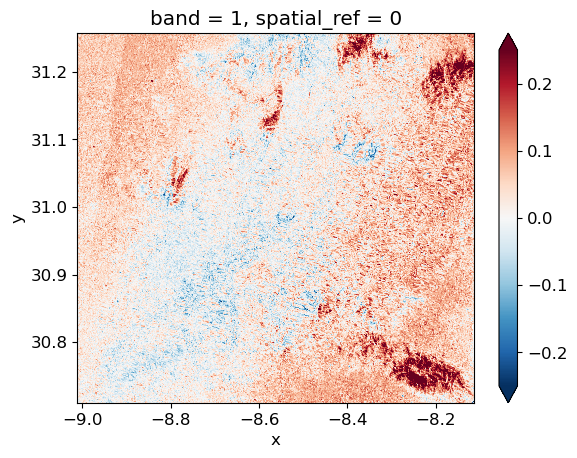

In [7]:
arr_amp = riox.open_rasterio(f"{geo_dir}/change_vv.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=-0.25, vmax=0.25, cmap="RdBu_r")

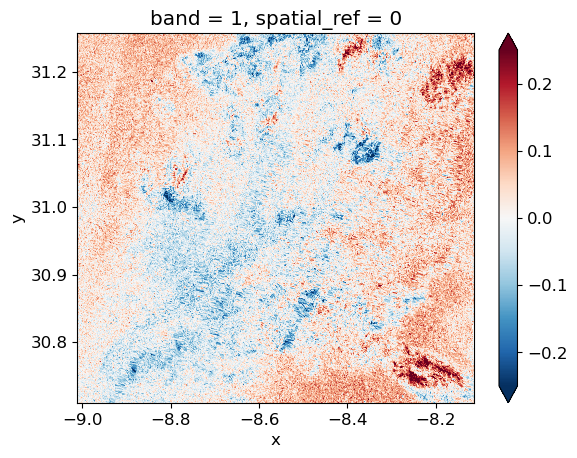

In [8]:
arr_amp = riox.open_rasterio(f"{geo_dir}/change_vh.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=-0.25, vmax=0.25, cmap="RdBu_r")

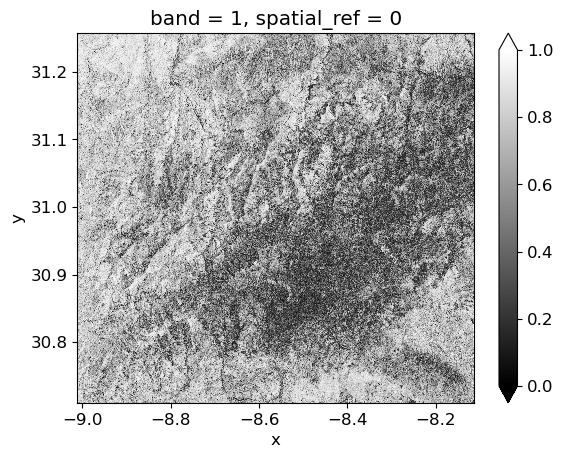

In [9]:
arr_coh = riox.open_rasterio(f"{geo_dir}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")

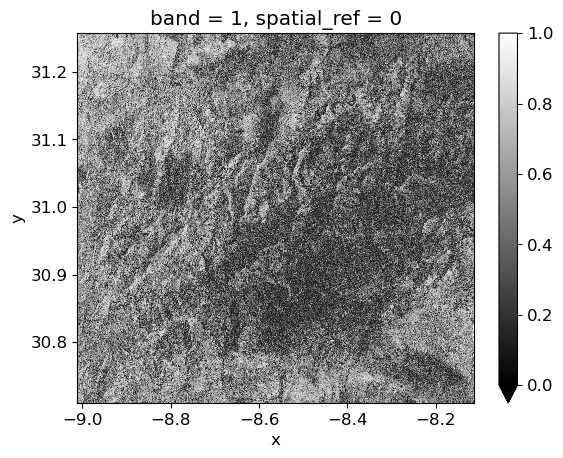

In [10]:
arr_coh = riox.open_rasterio(f"{geo_dir}/coh_vh.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")